<a href="https://colab.research.google.com/github/wolfisberg/zhaw-ba-online/blob/main/deepf0/DEEP_F0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install mir_eval
!pip install rt_pie
import os
import numpy as np
import tensorflow as tf
import scipy.interpolate
import matplotlib.pyplot as plt
import shutil
import datetime
import mir_eval
import math

%load_ext tensorboard

from google.colab import drive
drive.mount('/content/drive')

# Config

In [2]:
# Audio
SNR_RANGE = (-5.0,20.0) #dB
FRAME_LENGTH = 256
FRAME_STEP = 128
MIN_RAND_GAIN = 0.05
MAX_RAND_GAIN = 1.1
SAMPLE_LENGTH = 3 #shorter than shortest noise/speech sample
FS = 16000
PITCH_SAMPLING_TIME = 0.01 # s
PITCH_FRAME_LENGTH = 0.032 # s


# Data
BATCH_SIZE = 64
NUM_FRAMES = 1 + (FS * SAMPLE_LENGTH - FRAME_LENGTH) // FRAME_STEP
# NUM_FRAMES = 1

# Training
STEPS_PER_EPOCH = 500
EPOCHS = 100
VALIDATION_STEPS = 5


# Directories
_DATA_DIR = os.path.join('/content/drive/MyDrive/BA_2021/')
_TFRECORDS_DIR = os.path.join(_DATA_DIR, 'tfrecords')

SPEECH_DATA_TR_DIR = os.path.join(_TFRECORDS_DIR, 'speech', 'tr')
NOISE_DATA_TR_DIR = os.path.join(_TFRECORDS_DIR, 'noise', 'tr')
SPEECH_DATA_CV_DIR = os.path.join(_TFRECORDS_DIR, 'speech', 'cv')
NOISE_DATA_CV_DIR = os.path.join(_TFRECORDS_DIR, 'noise', 'cv')
SPEECH_DATA_TT_DIR = os.path.join(_TFRECORDS_DIR, 'speech', 'tt')
NOISE_DATA_TT_DIR = os.path.join(_TFRECORDS_DIR, 'noise', 'tt')

TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


# Misc
SEED = 2


# Parsing
PARSING_CONFIG_NOISE = {
    'data': tf.io.VarLenFeature(tf.string),
    'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
    'data_num_channels': tf.io.VarLenFeature(tf.int64),
    'data_width': tf.io.VarLenFeature(tf.int64),
}

PARSING_CONFIG_SPEECH = {
    'data': tf.io.VarLenFeature(tf.string),
    'data_sampling_rate': tf.io.VarLenFeature(tf.int64),
    'data_num_channels': tf.io.VarLenFeature(tf.int64),
    'data_width': tf.io.VarLenFeature(tf.int64),
    'pitch': tf.io.VarLenFeature(tf.float32),
    'pitch_confidence': tf.io.VarLenFeature(tf.float32),
}



# Data

## Copy Data to Runtime

In [3]:
DATA_DIR_LOCAL = '/content/data'

if not os.path.exists(DATA_DIR_LOCAL):
    os.mkdir(DATA_DIR_LOCAL)
    
    RECORD_DIR_LOCAL = os.path.join(DATA_DIR_LOCAL, 'tfrecords')
    shutil.copytree(_TFRECORDS_DIR, RECORD_DIR_LOCAL)


_TFRECORDS_DIR = os.path.join(DATA_DIR_LOCAL, 'tfrecords')

## Process Data

In [4]:
def _parse_noise_record(serialized_example):
    parsed_features = tf.io.parse_single_example(serialized_example, features=PARSING_CONFIG_NOISE)
    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features


def _parse_speech_record(serialized_example):
    parsed_features = tf.io.parse_single_example(serialized_example, features=PARSING_CONFIG_SPEECH)
    decoded_features = {
        "data_num_channels": tf.cast(parsed_features["data_num_channels"].values[0], tf.int32),
        "data_sampling_rate": tf.cast(parsed_features["data_sampling_rate"].values[0], tf.int32),
        "data_width": tf.cast(parsed_features["data_width"].values[0], tf.int32),
        "pitch": tf.cast(parsed_features['pitch'].values, tf.float32),
        "pitch_confidence": tf.cast(parsed_features['pitch_confidence'].values, tf.float32),
    }
    data = tf.io.decode_raw(parsed_features['data'].values[0], tf.int16)
    decoded_features.update({"data": data})
    return decoded_features


def _mix_noisy_speech(speech, noise):
    speech_pow = tf.math.reduce_euclidean_norm(speech)
    noise_pow = tf.math.reduce_euclidean_norm(noise)

    min_SNR = SNR_RANGE[0]
    max_SNR = SNR_RANGE[1]
    snr_current = 20.0*tf.math.log(speech_pow/noise_pow)/tf.math.log(10.0)
    snr_target = tf.random.uniform((),minval=min_SNR,maxval=max_SNR)

    noise = noise * tf.math.pow(10.0,(snr_current-snr_target)/20.0)
    noisy_speech = speech+noise

    return speech, noise, noisy_speech


def _interpolate_pitch(pitch,t):
    pitches = pitch.numpy()
    t = t.numpy()
    t_pitch = np.arange(0, len(pitch)) * PITCH_SAMPLING_TIME + PITCH_FRAME_LENGTH / 2
    f = scipy.interpolate.interp1d(t_pitch, pitch, 'nearest')
    return f(t).astype(np.float32)

def convert_hz_to_cent(f,fref=10.0):
    return mir_eval.melody.hz2cents(np.array(f), fref)

def calc_bin(freq_cent, cents_per_bin = 20, lower_bound_freq=32.7):  
    freq_cent = np.squeeze(freq_cent)
    lower_bound_freq_cent = mir_eval.melody.hz2cents(np.array([lower_bound_freq]))
    bin = (freq_cent - lower_bound_freq_cent) / np.array([cents_per_bin])
    return np.clip(bin, 0, 359)

def calc_y(f_groundtruth, n_bins = 360):
    c_true = calc_bin(f_groundtruth)
    return create_bin_vector(c_true)

def create_bin_vector(c_true):
    cis = np.arange(360)
    y = [gaussian_blur(cis, i) for i in c_true]
    return np.squeeze(y)
    
def gaussian_blur(ci, ctrue):
    return np.exp(-(ci-ctrue)**2/(2.0*25.0**2))

@tf.function
def _interpolate_pitch_tf(pitch,t):
    y = tf.py_function(_interpolate_pitch,[pitch,t], Tout=tf.float32)
    return tf.squeeze(y)

@tf.function
def _convert_hz_to_cent(pitch):
    y = tf.py_function(convert_hz_to_cent,[pitch], Tout=tf.float32)
    return tf.squeeze(y)

@tf.function
def _calc_y(pitch_cents):
    y = tf.py_function(calc_y,[pitch_cents], Tout=tf.float32)
    return tf.squeeze(y)

def _calc_features(speech_data, noise_data):
    speech = tf.squeeze(tf.cast(speech_data["data"], tf.float32))
    noise = tf.squeeze(tf.cast(noise_data["data"], tf.float32))
    speech = speech / tf.int16.max
    noise = noise / tf.int16.max

    random_start_idx = int(tf.round(tf.random.uniform([], maxval=(
             tf.cast(len(noise), tf.float32) - SAMPLE_LENGTH * FS - PITCH_SAMPLING_TIME))))
    noise = noise[random_start_idx:random_start_idx + SAMPLE_LENGTH * FS]

    random_start_idx = int(tf.round(tf.random.uniform([], minval=161, maxval=(
            tf.cast(len(speech), tf.float32) - SAMPLE_LENGTH * FS - 161))))
    speech = speech[random_start_idx:random_start_idx + SAMPLE_LENGTH * FS]   

    #SNR_range = SNR_RANGE
    frame_length = FRAME_LENGTH
    frame_step = FRAME_STEP
    speech, noise, noisy = _mix_noisy_speech(speech, noise)

    random_gain = tf.math.exp(
        tf.random.uniform([], minval=tf.math.log(MIN_RAND_GAIN), maxval=tf.math.log(MAX_RAND_GAIN)))
    noisy = random_gain * noisy

    noisy_frames = tf.signal.frame(noisy, frame_length, frame_step)
    speech_frames = tf.signal.frame(speech, frame_length, frame_step)
    noisy_frames = tf.squeeze(noisy_frames)
    speech_frames = tf.squeeze(speech_frames)
    #noisy_stft = tf.signal.stft(noisy,frame_length,frame_step)
    frame_times = random_start_idx / FS + tf.range(0, NUM_FRAMES) * frame_step / FS + frame_length / FS
    
    pitch = tf.squeeze(speech_data["pitch"])    
    pitch_confidence = tf.squeeze(speech_data["pitch_confidence"])
    #pitch = tf.where(pitch_confidence>config['pitch_confidence_threshold'],pitch,0)
    pitch_interpolated = _interpolate_pitch_tf(pitch, frame_times)
    pitch_interpolated_cents = _convert_hz_to_cent(pitch_interpolated)
    pitch_bins = _calc_y(pitch_interpolated_cents)
    return noisy_frames, pitch_bins

## Provide Data

In [5]:
def get_training_data():
    speech_ds = tf.data.TFRecordDataset([os.path.join(SPEECH_DATA_TR_DIR, file) for file in os.listdir(SPEECH_DATA_TR_DIR)])
    speech_ds = speech_ds.map(_parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    noise_ds = tf.data.TFRecordDataset([os.path.join(NOISE_DATA_TR_DIR, file) for file in os.listdir(NOISE_DATA_TR_DIR)])
    noise_ds = noise_ds.map(_parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
    dataset_features = dataset_combined.map(_calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_features = dataset_features.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    # just use if crepe without time component
    dataset_features = dataset_features.unbatch().unbatch().shuffle(3000).batch(BATCH_SIZE)
    return dataset_features


def get_validation_data():
    speech_ds = tf.data.TFRecordDataset([os.path.join(SPEECH_DATA_CV_DIR, file) for file in os.listdir(SPEECH_DATA_CV_DIR)])
    speech_ds = speech_ds.map(_parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    noise_ds = tf.data.TFRecordDataset([os.path.join(NOISE_DATA_CV_DIR, file) for file in os.listdir(NOISE_DATA_CV_DIR)])
    noise_ds = noise_ds.map(_parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)

    dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
    dataset_features = dataset_combined.map(_calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_features = dataset_features.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    # just use if crepe without time component
    dataset_features = dataset_features.unbatch().unbatch().shuffle(3000).batch(BATCH_SIZE)

    return dataset_features


def get_test_data():
    speech_ds = tf.data.TFRecordDataset([os.path.join(SPEECH_DATA_TT_DIR, file) for file in os.listdir(SPEECH_DATA_TT_DIR)])
    # speech_ds = speech_ds.map(_parse_speech_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)
    speech_ds = speech_ds.map(_parse_speech_record).repeat(10).shuffle(buffer_size=1000, seed=SEED)


    noise_ds = tf.data.TFRecordDataset([os.path.join(NOISE_DATA_TT_DIR, file) for file in os.listdir(NOISE_DATA_TT_DIR)])
    # noise_ds = noise_ds.map(_parse_noise_record).repeat(None).shuffle(buffer_size=1000, seed=SEED)
    noise_ds = noise_ds.map(_parse_noise_record).repeat(10).shuffle(buffer_size=1000, seed=SEED)


    dataset_combined = tf.data.Dataset.zip((speech_ds, noise_ds))
    dataset_features = dataset_combined.map(_calc_features, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset_features = dataset_features.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    # just use if crepe without time component
    dataset_features = dataset_features.unbatch().unbatch().shuffle(3000).batch(BATCH_SIZE)

    return dataset_features

# Models

## DEEP-F0 without time component

In [10]:
from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, Dropout, Permute, Flatten, Dense, Add, ReLU
from tensorflow.keras.models import Model

def resblock(x, filters, kernelsize, dilationrate, name):
    fx = Conv2D(filters, (64, 1), dilation_rate=(dilationrate, 1), padding='same',
                   activation='relu', name="dilation-conv%d" % name)(x)
    fx = BatchNormalization()(fx)
    fx = Conv2D(filters, 1, padding='same')(fx)
    out = Add()([x,fx])
    out = ReLU()(out)
    return out

def get_model_deepf0():
    layers = 1
    filters = 128
    width = 512
    strides = (16, 1)
    dilation_rate = 8

    x = Input(shape=(256,), name='input', dtype='float32')
    y = Reshape(target_shape=(256, 1, 1), name='input-reshape')(x)


    y = Conv2D(filters, (width, 1), strides=strides, padding='same',
                activation='relu')(y)
    for i in range(4):
        y = resblock(y, 128, 64, dilation_rate, name=i)
    y = AveragePooling2D(pool_size=(2, 1), strides=None, padding='valid',
                        name="conv1d-avgpool")(y)
    y = Permute((2, 1, 3), name="transpose")(y)
    y = Flatten(name="flatten")(y)
    y = Dense(360, activation='sigmoid', name="classifier")(y)
   

    model = Model(inputs=x, outputs=y)
    model.compile('adam', 'binary_crossentropy', metrics=['mse', 'mae'])

    return model

# Training

## Load Data

In [7]:
dataset_training = get_training_data()
dataset_validation = get_validation_data()
dataset_test = get_test_data()

## Load Model

In [8]:
model = get_model_deepf0()

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256)]        0                                            
__________________________________________________________________________________________________
input-reshape (Reshape)         (None, 256, 1, 1)    0           input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 1, 128)   65664       input-reshape[0][0]              
__________________________________________________________________________________________________
dilation-conv0 (Conv2D)         (None, 16, 1, 128)   1048704     conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Fit Model

In [ ]:
%tensorboard --logdir /content/drive/MyDrive/BA_2021/deepf0/logs

In [11]:
# USE IF IT IS INITIAL TRAINING

MODEL_USED = 'deepf0'
LOG_DIR = os.path.join(_DATA_DIR, MODEL_USED, 'logs', TIMESTAMP + '_256_128_100_Epochs')
if not os.path.exists(LOG_DIR):
    os.makedirs(LOG_DIR)
CHECKPOINT_DIR = os.path.join(_DATA_DIR, MODEL_USED, 'checkpoints', TIMESTAMP + '_256_128_100_Epochs')
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

In [ ]:
# JUST USE IF CONTINUING TRAINING

CHECKPOINT_DIR = '/content/drive/MyDrive/BA_2021/crepe/checkpoints/20210427-145400'
LOGDIR = '/content/drive/MyDrive/BA_2021/crepe/logs/20210427-145400'
model.load_weights(os.path.join('/content/drive/MyDrive/BA_2021/crepe/checkpoints', '20210427-145400', '50-2063.93.hdf5'))

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(LOG_DIR, histogram_freq=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR,'{epoch:02d}-{val_loss:.2f}.hdf5'))
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=32, mode='min')

callbacks = [checkpoint, tensorboard_callback, early_stopping]


history = model.fit(
    dataset_training,
    steps_per_epoch=500,
    epochs=100,
    # initial_epoch=30,
    verbose = 1,
    validation_data = dataset_validation,
    validation_steps=VALIDATION_STEPS,
    callbacks = callbacks)
    
loss = model.evaluate(dataset_test, steps=70)

Epoch 1/100
500/500 [==============================] - 41s 42ms/step - loss: 0.2435 - mse: 0.0416 - mae: 0.1081 - val_loss: 0.3043 - val_mse: 0.0530 - val_mae: 0.0934
Epoch 2/100
140/500 [=======>......................] - ETA: 8s - loss: 0.2093 - mse: 0.0303 - mae: 0.0828

# Predictions

In [ ]:
model.load_weights(os.path.join('/content/drive/MyDrive/BA_2021/deepf0/checkpoints', '20210429-083813', '50-0.18.hdf5'))

In [ ]:
def prediction():
    predicted_c = []
    true_c = []
    for inp, outp in dataset_test:
        predicted = model.predict(inp)
        true_cents = to_local_average_cents(outp)
        true_c.append(true_cents)
        predicted_cents = to_local_average_cents(np.squeeze(predicted))
        predicted_c.append(predicted_cents)

    true_c = np.reshape(np.array(true_c), (1, (len(true_c)*len(true_c[0]))))
    true_c = np.squeeze(true_c)
    true_hz = convert_cent_to_hz(true_c)
    predicted_c = np.reshape(np.array(predicted_c), (1, (len(predicted_c)*len(predicted_c[0]))))
    predicted_c = np.squeeze(predicted_c)
    predicted_hz = convert_cent_to_hz(predicted_c)
    diff = true_hz - predicted_hz
    return predicted_hz, true_hz, true_c, predicted_c, diff

In [ ]:
predicted_hz, true_hz, true_cent, predicted_cent, diff = prediction()

### Prediction Filtering

In [ ]:
## Hertz filter
combined = zip(true_hz, predicted_hz)
filtered = [x for x in list(combined) if x[0] > 0]
filtered_unzipped = np.array(list(zip(*filtered)))
diff_filtered = filtered_unzipped[0] - filtered_unzipped[1]

## Cent filter
combined_cent = zip(true_cent, predicted_cent)
filtered_cent = [x for x in list(combined_cent) if x[0] > 2072.0]
# filtered_c_unzipped = np.array(list(zip(*filtered_cent)))
# diff_filtered_cent = filtered_c_unzipped[0] - filtered_c_unzipped[1]

## Metrics

In [ ]:
from rt_pie.utils import metrics
hz_metrics = metrics.get_hz_metrics(true_hz, predicted_hz)
rpa_cent = metrics.raw_pitch_accuracy_cent(true_cent, predicted_cent)

## Plots

In [ ]:
def histogram(diff):  
    n_bins = 250
    x = diff
    y = true_hz

    plt.figure()
    plt.hist(x, bins=n_bins)
    #plt.xlim([-200, 200])
    plt.ylim([0, 10000])
    plt.xlabel("Error in Hertz")
    plt.ylabel("Number of Errors")
    plt.show()


# histo = histogram(diff)
# histo_true = histogram([x[0] - x[1] for x in filtered])

# Debug

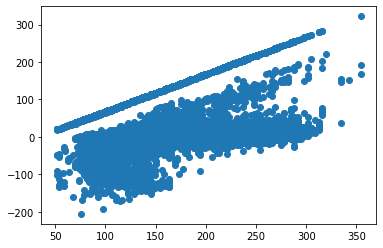

In [ ]:
err = np.array([x[0]-x[1] for x in filtered])
gt = np.array([x[0] for x in filtered])
est = np.array([x[1] for x in filtered])

plt.figure()
plt.scatter(gt,err)

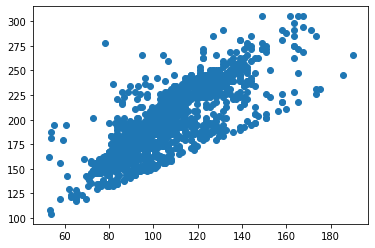

In [ ]:
plt.figure()
plt.scatter(gt[err < -50],est[err < -50])

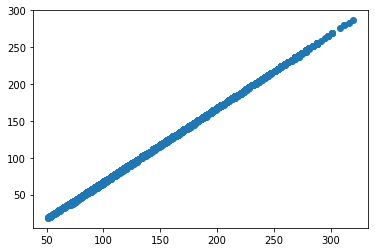

In [ ]:
plt.figure()
plt.scatter(gt[est<35],err[est<35])

In [ ]:
pred = model.predict(inp)

In [ ]:
for i in range(len(pred)):
    plt.figure(i)
    plt.plot(pred[i], 'b')
    plt.plot(outp[i], 'g')
    plt.show()

In [ ]:
pred = model.predict(inp)

In [ ]:
for i in range(len(pred)):
    plt.figure(i)
    plt.plot(pred[i], 'g')
    plt.plot(out[i], 'b')
    plt.show()

In [ ]:
for i in range(len(pred)):
    plt.figure(i)
    z = pred[i]
    y = out[i]
    plt.figure()
    plt.plot(z, 'b')
    plt.plot(y, 'r')
    plt.plot(np.argmax(z),np.max(z),'x')
    plt.plot(np.argmax(y),np.max(y),'x')
    plt.ylim([0, 1.1])
    plt.text(np.argmax(z)+10,np.max(z),f'max={np.max(z):.1f} @ bin {np.argmax(z)}')
    plt.text(np.argmax(y)+10,np.max(y),f'max={np.max(y):.1f} @ bin {np.argmax(y)}')
    plt.show()